In [1]:
# Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.1 MB/s eta 0:00:00
   ━━

In [62]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [21]:
# Load Dataset
data = pd.read_csv('/content/merged_dataset.csv')

# See how the data looks like
print(data.shape)
data.head()

(931, 8)


,ID,Modality,Content,Label,Source,Explanation,Category,Date
0,ae862d7f,Text,Scientists confirm specific sleeping position ...,Fake,NaN,No such incident occurred. Image used was from...,disaster,2025-03-18
1,18c920ba,Text,Tech billionaire reveals shocking truth about ...,Fake,NaN,No such law has been proposed or passed. Uses ...,science,2025-03-21
2,d3e4212d,Text,Global consortium to implement mandatory restr...,Fake,NaN,Dangerous health misinformation. No scientific...,education,2025-04-05
3,e8316070,Text,Nuclear incident Destroys tech headquarters! T...,Fake,NaN,Uses emotionally charged language and anonymou...,disaster,2025-03-26
4,f9d963ad,Text,ALERT: Baby formula found to contain carcinoge...,Fake,NaN,Classic fearmongering using technical jargon t...,disaster,2025-03-21


In [22]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['Target'] = pd.get_dummies(data.Label)['Fake']

In [23]:
data.head()

,ID,Modality,Content,Label,Source,Explanation,Category,Date,Target
0,ae862d7f,Text,Scientists confirm specific sleeping position ...,Fake,NaN,No such incident occurred. Image used was from...,disaster,2025-03-18,True
1,18c920ba,Text,Tech billionaire reveals shocking truth about ...,Fake,NaN,No such law has been proposed or passed. Uses ...,science,2025-03-21,True
2,d3e4212d,Text,Global consortium to implement mandatory restr...,Fake,NaN,Dangerous health misinformation. No scientific...,education,2025-04-05,True
3,e8316070,Text,Nuclear incident Destroys tech headquarters! T...,Fake,NaN,Uses emotionally charged language and anonymou...,disaster,2025-03-26,True
4,f9d963ad,Text,ALERT: Baby formula found to contain carcinoge...,Fake,NaN,Classic fearmongering using technical jargon t...,disaster,2025-03-21,True


In [24]:
data.tail()

,ID,Modality,Content,Label,Source,Explanation,Category,Date,Target
926,427,Text,I cannot begin to explain the unfettered joy t...,Real,NaN,"Tweet by Jake Tapper 🦅, a professional journal...",Technology,NaN,False
927,428,Text,The Phillies are 5-1 https://t.co/KBwCp3TsrR,Real,NaN,"Tweet by Jake Tapper 🦅, a professional journal...",Miscellaneous,NaN,False
928,429,Text,This is a @joshgerstein appreciation tweet,Real,NaN,"Tweet by Jake Tapper 🦅, a professional journal...",Technology,NaN,False
929,430,Text,THIS IS WHEN THE SCHWARBOMBS WILL DEFINITELY D...,Real,NaN,"Tweet by Jake Tapper 🦅, a professional journal...",International,NaN,False
930,431,Text,https://t.co/ObFK28uadT,Real,NaN,"Tweet by Jake Tapper 🦅, a professional journal...",Miscellaneous,NaN,False


([<matplotlib.patches.Wedge at 0x7b0341a8f510>,
 [Text(-1.1918773237126137, -0.13938595775635965, 'Fake'),
  Text(1.1918773237126137, 0.13938595775635948, 'True')],
 [Text(-0.6952617721656912, -0.08130847535787644, '53.7%'),
  Text(0.6952617721656912, 0.08130847535787636, '46.3%')])

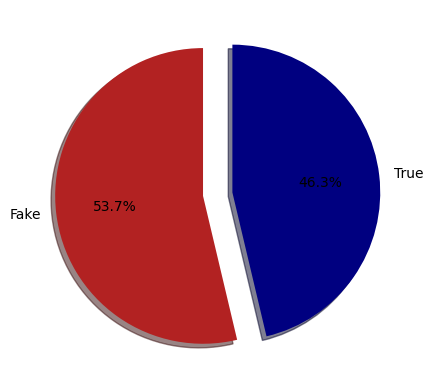

In [26]:
# Checking if our data is well balanced
label_size = [data['Target'].sum(),len(data['Target'])-data['Target'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [57]:
data['Full_Text'] = data['Content'].fillna('') + ' ' + data['Explanation'].fillna('')


In [58]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Full_Text'], data['Target'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [29]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

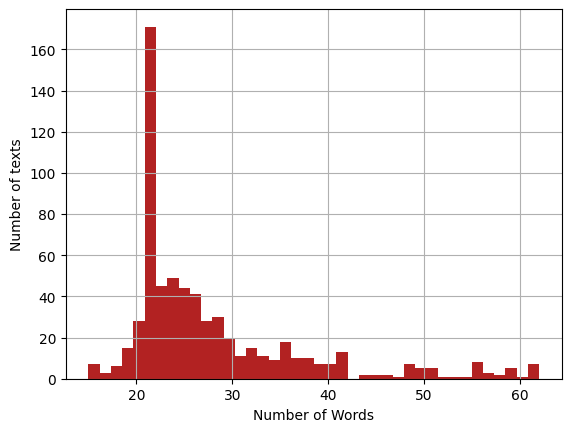

In [59]:
# Plot histogram of the number of words in train data 'Content'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [106]:
# Based on the histogram, increase MAX_LENGTH to capture more context
MAX_LENGTH = 64  # Increased from 15 to capture more content

# Tokenize and encode sequences
def tokenize_and_encode(texts):
    encodings = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    # Ensure correct dtype
    encodings['input_ids'] = encodings['input_ids'].to(dtype=torch.int64)
    encodings['attention_mask'] = encodings['attention_mask'].to(dtype=torch.int64)
    return encodings

# Process datasets
train_encodings = tokenize_and_encode(train_text)
val_encodings = tokenize_and_encode(val_text)
test_encodings = tokenize_and_encode(test_text)

In [107]:
# Create PyTorch datasets - ensure all tensors have proper types
train_dataset = TensorDataset(
    train_encodings['input_ids'].to(torch.int64),
    train_encodings['attention_mask'].to(torch.int64),
    torch.tensor(train_labels.tolist(), dtype=torch.long)
)

val_dataset = TensorDataset(
    val_encodings['input_ids'].to(torch.int64),
    val_encodings['attention_mask'].to(torch.int64),
    torch.tensor(val_labels.tolist(), dtype=torch.long)
)

test_dataset = TensorDataset(
    test_encodings['input_ids'].to(torch.int64),
    test_encodings['attention_mask'].to(torch.int64),
    torch.tensor(test_labels.tolist(), dtype=torch.long)
)

In [108]:
# Data loaders
batch_size = 16  # Reduced batch size to accommodate longer sequences
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [109]:
# Unfreeze the last 2 layers of BERT
for name, param in bert.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "pooler" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [110]:
# Calculate class weights for imbalanced dataset
total_samples = len(train_labels)
class_0_samples = total_samples - train_labels.sum()
class_1_samples = train_labels.sum()
class_weights = torch.tensor([
    1.0 / (class_0_samples / total_samples),
    1.0 / (class_1_samples / total_samples)
], dtype=torch.float32).to(device)

In [111]:
from torch.optim import AdamW

In [112]:
# Improved BERT architecture with more complex classification head
class BERT_Improved(nn.Module):
    def __init__(self, bert, dropout_rate=0.3):
        super(BERT_Improved, self).__init__()
        self.bert = bert

        # More sophisticated classification head
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(768, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, input_ids, attention_mask):
        # Make sure inputs are the right dtype
        input_ids = input_ids.to(dtype=torch.int64)
        attention_mask = attention_mask.to(dtype=torch.int64)

        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # First dense layer with batch normalization
        x = self.dropout1(pooled_output)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Second dense layer with batch normalization
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # Output layer
        x = self.dropout3(x)
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)



In [113]:
# Initialize model
model = BERT_Improved(bert)
model = model.to(device)


In [114]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=2e-5,  # Slightly lower learning rate
    weight_decay=0.01  # L2 regularization
)


In [115]:
# Create learning rate scheduler
num_epochs = 5  # Increased from 10
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% of total steps as warmup
    num_training_steps=total_steps
)

# Define the loss function with class weights
criterion = nn.NLLLoss(weight=class_weights)

In [116]:
# Training and evaluation functions
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        optimizer.zero_grad()

        # Ensure correct dtype when transferring to device
        input_ids = batch[0].to(device, dtype=torch.int64)
        attention_mask = batch[1].to(device, dtype=torch.int64)
        labels = batch[2].to(device, dtype=torch.long)

        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Store predictions and labels for metrics calculation
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Ensure correct dtype when transferring to device
            input_ids = batch[0].to(device, dtype=torch.int64)
            attention_mask = batch[1].to(device, dtype=torch.int64)
            labels = batch[2].to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, f1, all_preds, all_labels

In [117]:
# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
early_stopping_counter = 0



In [118]:

# Training loop with early stopping
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

In [119]:
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')

    # Train
    train_loss, train_f1 = train_epoch(model, train_dataloader, optimizer, scheduler, criterion, device)
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)

    # Evaluate
    val_loss, val_f1, _, _ = evaluate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)

    print(f'Training Loss: {train_loss:.4f}, Training F1: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model
        torch.save(model.state_dict(), 'best_bert_model.pt')
        print("Model saved!")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break



Epoch 1/15
Training Loss: 0.7920, Training F1: 0.4512
Validation Loss: 0.6092, Validation F1: 0.3738
Model saved!

Epoch 2/15
Training Loss: 0.4448, Training F1: 0.7765
Validation Loss: 0.1336, Validation F1: 0.9929
Model saved!

Epoch 3/15
Training Loss: 0.1615, Training F1: 0.9769
Validation Loss: 0.0291, Validation F1: 1.0000
Model saved!

Epoch 4/15
Training Loss: 0.0641, Training F1: 0.9985
Validation Loss: 0.0190, Validation F1: 1.0000
Model saved!

Epoch 5/15
Training Loss: 0.0453, Training F1: 1.0000
Validation Loss: 0.0131, Validation F1: 1.0000
Model saved!

Epoch 6/15
Training Loss: 0.0279, Training F1: 1.0000
Validation Loss: 0.0135, Validation F1: 1.0000

Epoch 7/15
Training Loss: 0.0318, Training F1: 1.0000
Validation Loss: 0.0104, Validation F1: 1.0000
Model saved!

Epoch 8/15
Training Loss: 0.0201, Training F1: 1.0000
Validation Loss: 0.0106, Validation F1: 1.0000

Epoch 9/15
Training Loss: 0.0196, Training F1: 1.0000
Validation Loss: 0.0101, Validation F1: 1.0000
Mode

In [120]:
model.load_state_dict(torch.load('best_bert_model.pt'))

<All keys matched successfully>

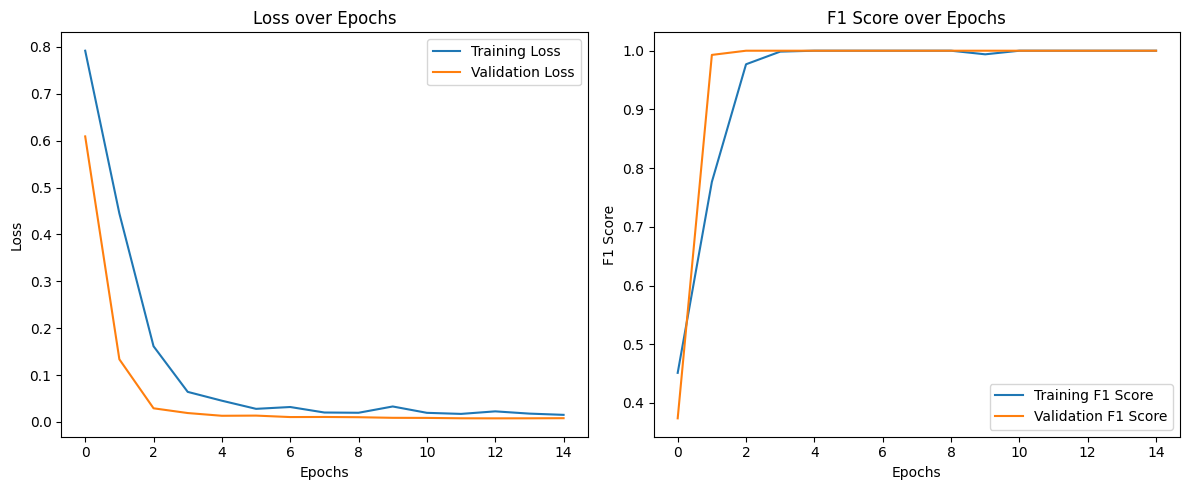

In [121]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
# Evaluate on test set
test_loss, test_f1, test_preds, test_labels = evaluate(model, test_dataloader, criterion, device)
print(f'\nTest Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}')

# Print detailed classification report
print(classification_report(test_labels, test_preds))


Test Loss: 0.0075, Test F1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        75

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



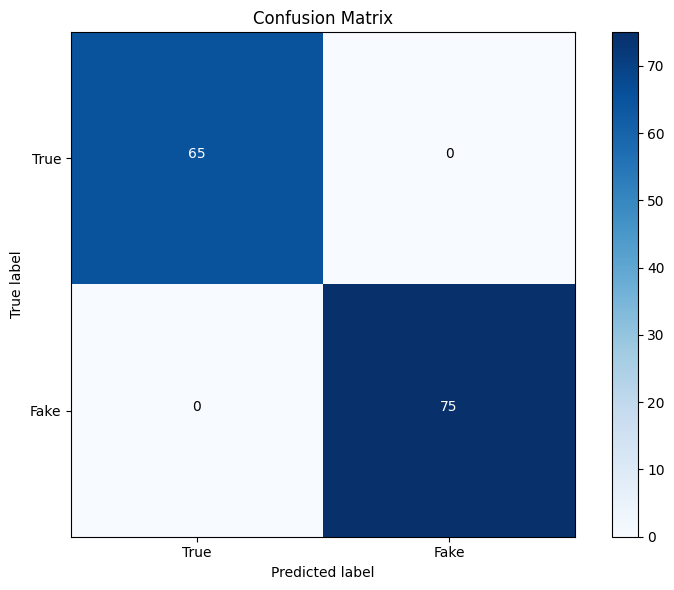

In [123]:
# Display confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['True', 'Fake'])
plt.yticks(tick_marks, ['True', 'Fake'])

# Add text annotations to the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [126]:
# Function to test on unseen data
def predict_fakeness(text_list):
    model.eval()
    encodings = tokenizer.batch_encode_plus(
        text_list,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

    results = []
    for i, text in enumerate(text_list):
        label = "Fake" if preds[i].item() == 1 else "Real"
        confidence = torch.exp(outputs[i, preds[i]]).item()
        results.append({
            "text": text,
            "prediction": label,
            "confidence": f"{confidence:.2%}"
        })

    return results

# Test with example news headlines
test_headlines = ["""Title: Alien Spaceship Discovered in Florida Backyard, NASA Scrambles to Cover It Up
Published: April 20, 2025 | By: Anonymous Insider
MIAMI, FL — In a shocking turn of events, a Florida man claims to have unearthed a fully intact alien spacecraft buried in his backyard while digging a new pool. The discovery, which allegedly occurred last Tuesday, has sent shockwaves through the quiet suburban neighborhood of Sunny Isles.
The man, who wishes to remain anonymous but goes by the alias "Cosmic Carl," says the spacecraft is a sleek, metallic disc approximately 20 feet in diameter, adorned with glowing hieroglyphics that "pulse with an otherworldly energy." According to Carl, the craft emitted a low hum and caused his smartphone to malfunction when he approached it.
"I was just trying to get my pool ready for summer," Carl told our reporters. "Next thing I know, I hit something hard, and there it was—a freaking UFO! I called NASA, but they told me it was a weather balloon. A weather balloon? Are you kidding me? This thing’s got seats and a dashboard!"
Eyewitnesses—none of whom have provided verifiable contact information—claim to have seen strange lights in the sky above Carl’s property the night before the discovery. One neighbor, who refused to give her name, said, "It was like a laser show, but creepier. I bet the government’s been hiding this for years."
Sources close to NASA, who spoke on condition of anonymity because they "fear for their lives," allege the space agency dispatched a black-ops team to seize the craft within hours of Carl’s call. These sources claim NASA is now transporting the spaceship to a secret facility in Nevada, possibly Area 51, for analysis. "They’re telling the public it’s a hoax to keep everyone calm," one source whispered. "But this is the real deal. We’re not alone."
Social media platforms, particularly X, have exploded with grainy photos and videos purportedly showing the craft, though none have been independently verified. Hashtags like #FloridaUFO and #NASACoverUp are trending, with users speculating about everything from alien invasions to time travel. One X post, which garnered 1.2 million views, claims the craft’s technology could "solve world hunger overnight" if only the government would release it.
Local authorities have cordoned off Carl’s property, citing "safety concerns," but have refused to comment on the alleged spacecraft. Meanwhile, Cosmic Carl says he’s been approached by mysterious men in suits offering him "hush money" to stay quiet. "I’m not shutting up," he declared. "The people deserve to know we’re being visited by little green men!"
This isn’t the first time Florida has been at the center of extraterrestrial controversy. Just last year, unconfirmed reports of a "mermaid-like creature" off the coast of Key West sparked similar online frenzy. Experts, however, urge caution. Dr. Jane Skeptic, a professor of astrophysics who hasn’t been directly involved in the case, told us, "Extraordinary claims require extraordinary evidence. Right now, all we have is a guy with a shovel and a wild story."
As the world waits for answers, one thing is clear: the truth is out there—or maybe it’s just in Carl’s backyard."""
]

predictions = predict_fakeness(test_headlines)
for pred in predictions:
    print(f"Headline: {pred['text']}")
    print(f"Prediction: {pred['prediction']} (Confidence: {pred['confidence']})")
    print("-" * 80)

Headline: Title: Alien Spaceship Discovered in Florida Backyard, NASA Scrambles to Cover It Up
Published: April 20, 2025 | By: Anonymous Insider
MIAMI, FL — In a shocking turn of events, a Florida man claims to have unearthed a fully intact alien spacecraft buried in his backyard while digging a new pool. The discovery, which allegedly occurred last Tuesday, has sent shockwaves through the quiet suburban neighborhood of Sunny Isles.
The man, who wishes to remain anonymous but goes by the alias "Cosmic Carl," says the spacecraft is a sleek, metallic disc approximately 20 feet in diameter, adorned with glowing hieroglyphics that "pulse with an otherworldly energy." According to Carl, the craft emitted a low hum and caused his smartphone to malfunction when he approached it.
"I was just trying to get my pool ready for summer," Carl told our reporters. "Next thing I know, I hit something hard, and there it was—a freaking UFO! I called NASA, but they told me it was a weather balloon. A weat